<a href="https://colab.research.google.com/github/annulet/CNN_NVIDIA/blob/master/hw_6_face_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

##Загрузка датасета LFW

In [3]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete6J74SD/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [5]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

Label: b'Tom_Amstutz'


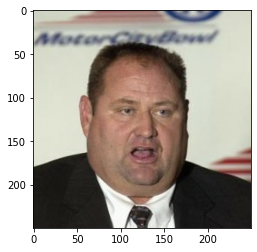

In [6]:
for example in train_ds.take(1):  # Only take a single example
    image, label = example[1], example[0]

    plt.imshow(image.numpy().astype(np.float32)/255)
    print(f"Label: {label}")

##Создание модели CNN

In [0]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

##Contrastive Loss

In [0]:
MARGIN = 50.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

##Подготовка пайплайна данных

In [0]:
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [0]:
BATCH_SIZE = 128
NUM_EPOCHS = 10

train_ds = train_ds.map(normalize_example)
train_ds = train_ds.shuffle(buffer_size=10000, seed=5)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [12]:
train_ds

<DatasetV1Adapter shapes: ((None,), (None, 250, 250, 3)), types: (tf.string, tf.float32)>

##Визуализация датасета

In [0]:
some_sample = next(iter(train_ds))
images = some_sample[1].numpy()[:4]
labels = some_sample[0].numpy()[:4]

In [18]:
labels

array([b'Tom_Craddick', b'Sigourney_Weaver', b'Mitchell_Daniels',
       b'Britney_Spears'], dtype=object)

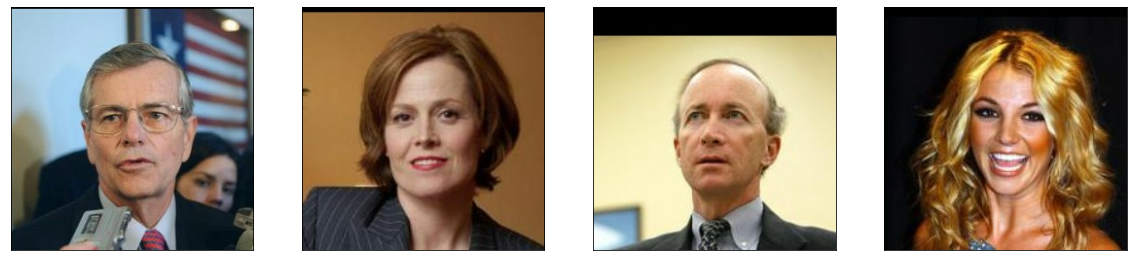

In [19]:
fontdict = {'fontsize': '14', 'color': 'white'}
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i].reshape(250,250,3))
    plt.xlabel(labels[i].decode(), fontdict=fontdict)
plt.show()

##Подготовка к обучению

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

##Обучение модели

In [21]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 2477.537841796875
[200] Loss: 0.0007621707627549767
[400] Loss: 2.451477527618408
[600] Loss: 0.0
[800] Loss: 61.725650787353516
[1000] Loss: 0.0
CPU times: user 10min 41s, sys: 5min 42s, total: 16min 24s
Wall time: 20min 10s


##Тестирование на новых данных

In [0]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('https://v-kurse.ru/upload/iblock/b8f/b8feb2a79c70c781623c12cda8e30586.jpg')
img_a2 = load_and_prepare_image('https://avatars.mds.yandex.net/get-pdb/1572252/266947e4-b66a-40b9-bc2d-0dbab6fb86f8/s1200?webp=false')
img_b = load_and_prepare_image('https://sm-news.ru/wp-content/uploads/2020/01/12/putin-ulybaetsja.jpg')
img_c = load_and_prepare_image('https://interkomitet.ru/wp-content/uploads/2017/11/399.jpg')

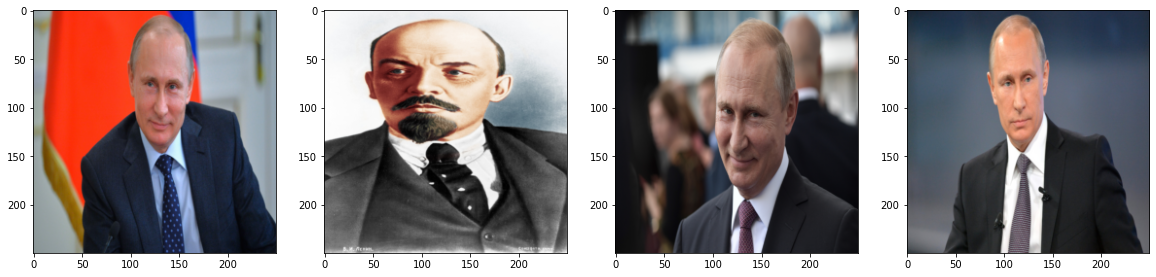

In [31]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_b)
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_c)
plt.show()

##Получение эмбеддингов для новых данных

In [0]:
new_embs = model(np.stack((img_a1, img_a2, img_b, img_c), axis=0))

##Вычисление расстояний между эмбеддингами

In [32]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:] 
emb2 = new_embs[1,:] 
emb3 = new_embs[2,:] 
emb4 = new_embs[3,:] 

print('Putin1 <-> Lenin: ', diff(emb1, emb2))
print('Putin1 <-> Putin2: ', diff(emb1, emb3))
print('Lenin <-> Putin2: ', diff(emb2, emb3))
print('Putin1 <-> Putin3: ', diff(emb1, emb4))
print('Lenin <-> Putin3: ', diff(emb2, emb4))

Putin1 <-> Lenin:  778.8506756753826
Putin1 <-> Putin2:  149.0424383774635
Lenin <-> Putin2:  726.912348567556
Putin1 <-> Putin3:  171.69653803112922
Lenin <-> Putin3:  795.6602996882526


Эмбеддинги фотографий Путина оказались ближе, чем эмбеддинги фотографий 2 разных людей (Путина и Ленина).

#Сравним фотографии из обучающего датасета с фотографиями из интернета тех же людей: Sigourney_Weaver, Britney_Spears.

##Получение эмбеддингов для картинок из трейна

In [0]:
train_embs = model(images)

In [0]:
train_emb1 = train_embs[1,:] #Sigourney Weaver
train_emb4 = train_embs[3,:] #Britney Spears


##Загрузка фотографий из интернета

In [0]:
img_a = load_and_prepare_image('https://i.pinimg.com/736x/3a/2c/3c/3a2c3c0ce7696ee6588dea998af8d43d--sigourney-weaver-super-star.jpg')
img_b = load_and_prepare_image('https://condenast-media.gcdn.co/glamour/8603fe3440f9735ee566dee7e899da8e.jpg/c1f1d322/c1600x1600x0x108/w2000')

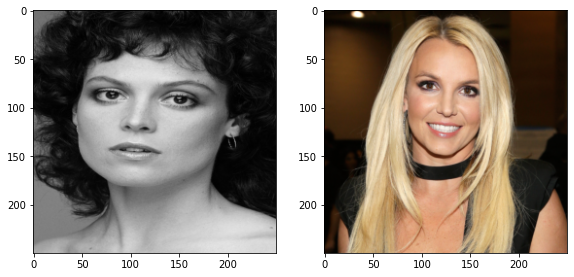

In [50]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_b)

plt.show()

In [0]:
embs = model(np.stack((img_a, img_b), axis=0))

emb1 = embs[0,:]
emb2 = embs[1,:] 

In [53]:
print('Sigourney <-> Sigouney: ', diff(emb1, train_emb1))
print('Britney <-> Britney: ', diff(emb2, train_emb4))

Sigourney <-> Sigouney:  692.9475088345437
Britney <-> Britney:  574.3298268416851


Здесь мы видим, что расстояния между эмбеддингами одних и тех же людей сравнимы с расстояниями между эмбеддингами разных людей в первом эксперименте. Видимо нужны фотки одного возраста.